In [50]:
import yaml
from yaml.loader import SafeLoader
from socket import gethostname
import numpy as np
import pandas as pd
from sklearn.base import clone
from dev_interaction_util import generate_synthetic_dev_outcomes, generate_synthetic_dev_data, set_up_interactions
from dev_interaction_util import do_scoring_loop, get_best_model, summarize_overall_df_results, do_final_fit, present_model_results, present_results_vs_ground_truth_cors
from dev_interaction_util import load_and_preprocess_data, impute_data
from ml_util import *
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import linear_model
from ml_util import get_data_for_imputation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import numpy as np
from IPython.display import display, HTML
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFE


In [51]:


print(gethostname())
# Open the file and load the file
with open('config.yml') as f:
    all_yaml = yaml.load(f, Loader=SafeLoader)
    if gethostname() in all_yaml.keys():
        config = all_yaml[gethostname()]
    else:
        config = all_yaml['default']
        
print(config)



Benjamins-MacBook-Pro-2.local
{'dropbox_data_dir': '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/'}


This notebook is derived from `test_feature_selection.ipynb`.

In [52]:
dropbox_data_dir = config['dropbox_data_dir']


In [53]:
analysis_data, outcome_measures = load_and_preprocess_data(dropbox_data_dir)

In [54]:
#import pyplot
import matplotlib.pyplot as plt


def impute_data(analysis_data,graph_against_col=None):
    """
    Does data imputing. Should not be used for a final analysis, because
    imputing of data should occur within the pipeline, so has not to permit data leakage
    """

    imputer = IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100,random_state=0)
    analysis_data_imputed = get_data_for_imputation(analysis_data)

    #this dataset is already filtered for columns so we don't need to filter those further.
    analysis_data_imputed = pd.DataFrame(imputer.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
    imputed_data = analysis_data.isna()
    # do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,'ridge_10')
    if graph_against_col is not None:
        cols_with_imputed_data = analysis_data_imputed.columns[imputed_data.sum()>0]
        for i, col in enumerate(cols_with_imputed_data):
            #get a column indicating whether each point in this column was imputed
            imputed_datapoint = imputed_data.loc[:,col]
            #plot a scatter plot of the outcome measure against the imputed data
            #color the columns by whether they were imputed or not
            fig, ax = plt.subplots()
            ax.scatter(analysis_data_imputed.loc[:,col],graph_against_col,c=imputed_datapoint.astype(int))
            ax.set_xlabel(col)
            ax.set_ylabel("outcome")
            ax.set_title('Imputed ' + col + ' vs outcome')
            #add a legend to the plot
            ax.legend(['not imputed','imputed'])
            plt.show()

            #only do three columns
            if i>2:
                break







    return(analysis_data_imputed)





/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


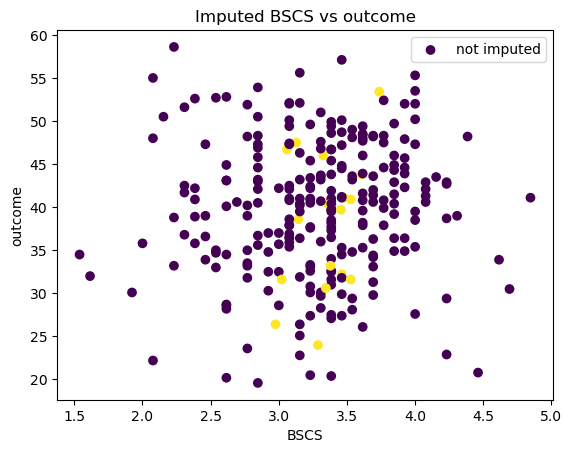

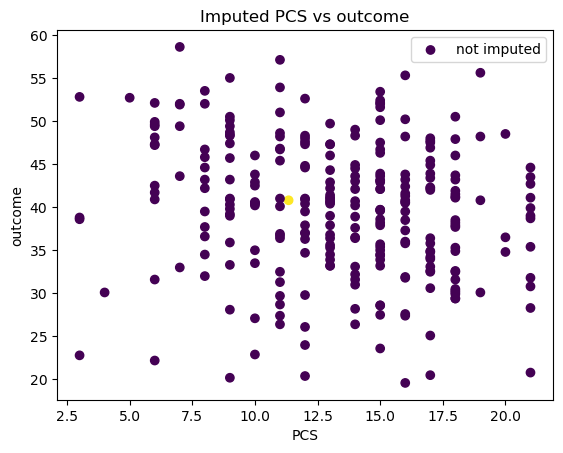

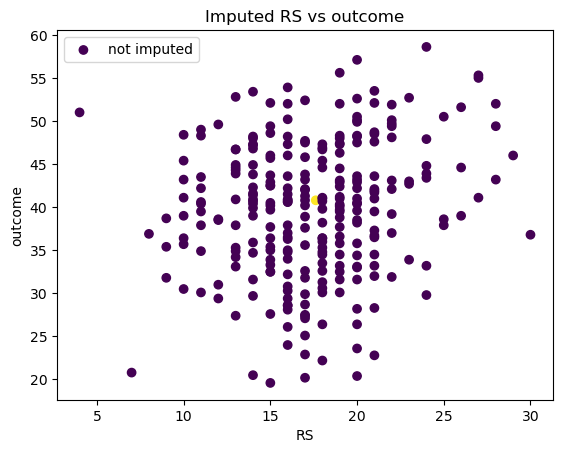

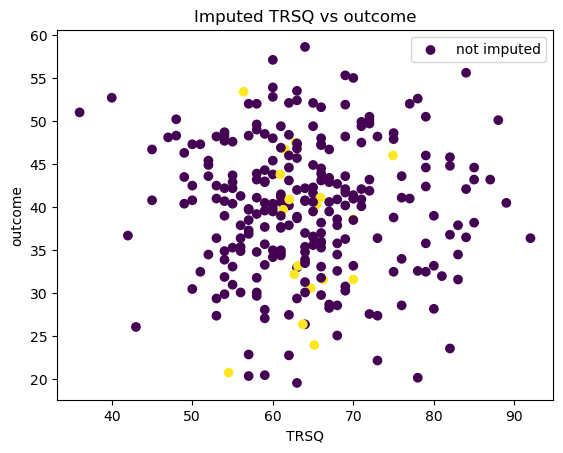

In [55]:
analysis_data_imputed = impute_data(analysis_data, graph_against_col=outcome_measures['bf_1'])

In [56]:

#loops through the different estimators and feature selection methods and does a grid search over all to find the best hyperparameters
def do_hyperparameter_selection_loop(X, y,cv):
    #alpha parameters for Ridge and Lasso
    alpha_10pow_lower = 1
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])

    all_cv_results = []

    pipeline_estimator_name = 'estimator'
    feature_selection_name = 'feature_selection'


    #define the param_grid for the estimators
    estimators_to_run = {
        'Ridge':{
            'estimator':linear_model.Ridge,
            'parameters':{'alpha':alpha_range}
        },
        'Lasso':{
            'estimator':linear_model.Lasso,
            'parameters':{'alpha':alpha_range}
        },
        'DecisionTreeRegressor':{
            'estimator':DecisionTreeRegressor,
            'parameters':{
                'max_depth':[2, 4],
                'min_samples_split':[20,50],
                'min_samples_leaf':[20,50]
            }
        }             
    }

    k_max_val = np.min([50,X.shape[1]])

    for estimator_name,estimator_dict in estimators_to_run.items():
        #param grid for the feature seelction
        #this is here because we need to know the estimator to pass to the feature selector
        feature_selectors_to_run = {
            'None':None,
            'KBest':{
                'selector':SelectKBest(),
                'parameters':{
                    'score_func' : [f_regression], 
                    'k' : [20,k_max_val]
                    }
            },
            'RFE':{
                'selector':RFE(linear_model.LinearRegression()),
                'parameters':{
                    'n_features_to_select' : [10,25],
                    #'verbose':[1],
                    'step':[5]
                }
            }
        }
        for selector_name, selector_dict in feature_selectors_to_run.items():
        #create the estimator
            if selector_name == 'None':
                pipeline = Pipeline([('scaler',StandardScaler()),
                                        (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = {}
            else:
                pipeline = Pipeline([('scaler',StandardScaler()),
                                        (feature_selection_name,selector_dict['selector']), 
                                        (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = selector_dict['parameters']

            estimator_param_grid = {(pipeline_estimator_name + '__'+k):v for k,v in estimator_dict['parameters'].items()}
            selector_param_grid = {(feature_selection_name + '__'+k):v for k,v in selector_params.items()}
            #combine the two param grid dictionaries
            full_param_grid = {**selector_param_grid, **estimator_param_grid}
            print(pipeline)
            print(full_param_grid)

            
        
            gs_1 = GridSearchCV(estimator=pipeline, 
                                param_grid = full_param_grid, 
                                cv=cv,scoring='neg_mean_absolute_error',verbose=1)
            gs_1.fit(X,y)
            all_cv_results.append(gs_1)

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })

    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }





In [57]:
#simulator settings
interaction_effect_size_as_sd=0.1
total_predictor_count=20

In [58]:
#def run_full_limited_predictor_analysis(total_predictor_count, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.08):


#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])


#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

#create a limited set of predictors
analysis_data_smol = analysis_data_imputed.iloc[:,0:total_predictor_count]

# add synthetic primary and interaction effects


#set up the interaction effects
#0.08 will give us correlations around 0.3 between the interaction effects and the outcome
custom_interaction_effects_g1 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g1[0] = interaction_effect_size_as_sd
custom_interaction_effects_g1[1] = interaction_effect_size_as_sd
custom_interaction_effects_g1[2] = -interaction_effect_size_as_sd

custom_interaction_effects_g2 = [0]*analysis_data_smol.shape[1]
custom_interaction_effects_g2[4] = interaction_effect_size_as_sd
custom_interaction_effects_g2[5] = interaction_effect_size_as_sd
custom_interaction_effects_g2[6] = -interaction_effect_size_as_sd

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_smol, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_smol, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]



['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

In [59]:
### Try out CV with simple gridsearch

scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_loop,
                outer_folds=5)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']


outer split0
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Ridge())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x180f38940>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits


KeyboardInterrupt: 

In [25]:

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit, y=outcome_measures_nona['d_bf'])

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

result_details = present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results,base_regressors)

empirical_corr_diff_mean = np.mean(np.abs(result_details['group_correlations']['san_cor']-result_details['group_correlations']['ni_cor']))

# return({
#     'overall_score':overall_score,
#     'empirical_corr_diff_mean':empirical_corr_diff_mean,
#     'result_details':result_details
# })




['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 11


,predictor,coef,feature_importance,fa_abs
12,BSCS*ni,0.972764,0.119505,0.119505
26,RS*san,0.581897,0.049022,0.049022
2,BIS_11,-0.392702,0.023960,0.023960
6,ACES_neglectful_parenting,-0.275182,0.015961,0.015961
30,ACES_sum*san,-0.156225,0.005204,0.005204
19,ACES_abuse*ni,-0.109025,0.003821,0.003821
7,ACES_abuse,0.159900,0.003787,0.003787
1,EDM,0.119865,0.003041,0.003041
5,TRSQ,0.107321,0.003011,0.003011
20,ACES_sum*ni,-0.018454,0.000429,0.000429


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:347: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.000,0.973,-0.000,0.000,0.120,0.000,-0.137,0.350,0.008,0.120
RS,NaN,NaN,0.582,NaN,NaN,0.049,0.039,-0.154,0.260,0.049
BIS_11,-0.393,-0.000,0.000,0.024,0.000,0.000,0.047,-0.383,-0.043,0.024
ACES_neglectful_parenting,-0.275,0.022,NaN,0.016,0.000,NaN,-0.046,-0.017,-0.218,0.016
ACES_abuse,0.160,-0.109,-0.000,0.004,0.004,0.000,NaN,NaN,NaN,0.008
ACES_sum,0.000,-0.018,-0.156,0.000,0.000,0.005,NaN,NaN,NaN,0.006
EDM,0.120,NaN,-0.000,0.003,NaN,0.000,0.053,0.233,-0.056,0.003
TRSQ,0.107,-0.000,0.000,0.003,0.000,0.000,0.091,-0.222,0.264,0.003


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2138921023.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':10,'overall_score':overall_score},ignore_index=True)


## 20 variables



In [27]:
#run the analysis with a limited number of predictors
predictors = 20

overall_score = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed)

overall_scores = overall_scores.append({'n_features':predictors,'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 9


,predictor,coef,feature_importance,fa_abs
22,BSCS*ni,1.724228,0.371292,0.371292
55,BFI_extraversion*san,0.792246,0.097368,0.097368
24,BIS_11*ni,-0.611822,0.060679,0.060679
48,ACES_neglectful_parenting*san,-0.425717,0.025208,0.025208
32,ACES_household_dysfunction*ni,-0.234528,0.011571,0.011571
29,ACES_abuse*ni,-0.127256,0.005014,0.005014
51,ACES_divorced_separated*san,-0.161720,0.002590,0.002590
7,ACES_abuse,0.133042,0.002256,0.002256
10,ACES_household_dysfunction,0.027042,0.000317,0.000317
47,TRSQ*san,0.000000,0.000000,0.000000


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:347: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,1.724,-0.000,NaN,0.371,0.000,-0.137,0.350,0.008,0.371
BFI_extraversion,NaN,NaN,0.792,NaN,NaN,0.097,NaN,NaN,NaN,0.097
BIS_11,NaN,-0.612,NaN,NaN,0.061,NaN,0.047,-0.383,-0.043,0.061
ACES_neglectful_parenting,-0.000,0.000,-0.426,0.000,0.000,0.025,-0.046,-0.017,-0.218,0.025
ACES_household_dysfunction,0.027,-0.235,-0.000,0.000,0.012,0.000,NaN,NaN,NaN,0.012
ACES_abuse,0.133,-0.127,0.000,0.002,0.005,0.000,NaN,NaN,NaN,0.007
ACES_divorced_separated,-0.000,-0.000,-0.162,0.000,0.000,0.003,NaN,NaN,NaN,0.003


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4201306047.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':overall_score},ignore_index=True)


The real final test might be how good the predictor is at choosing an intervention for a given individual. But we can't test that.

## 40 variables

In [28]:
#run the analysis with a limited number of predictors
predictors = 40

overall_score = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed)

overall_scores = overall_scores.append({'n_features':predictors,'overall_score':overall_score},ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 4


,predictor,coef,feature_importance,fa_abs
42,BSCS*ni,0.745645,0.080712,0.080712
95,BFI_extraversion*san,0.403294,0.035082,0.035082
88,ACES_neglectful_parenting*san,-0.194826,0.008660,0.008660
6,ACES_neglectful_parenting,-0.059079,0.001749,0.001749
82,BSCS*san,0.000000,0.000000,0.000000
99,IMI_effort_importance*san,0.000000,0.000000,0.000000
94,BFI_conscientiousness*san,0.000000,0.000000,0.000000
93,BFI_agreeableness*san,0.000000,0.000000,0.000000
92,ACES_household_dysfunction*san,-0.000000,0.000000,0.000000
91,ACES_divorced_separated*san,-0.000000,0.000000,0.000000


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:347: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,0.746,0.000,NaN,0.081,0.000,-0.137,0.350,0.008,0.081
BFI_extraversion,NaN,NaN,0.403,NaN,NaN,0.035,NaN,NaN,NaN,0.035
ACES_neglectful_parenting,-0.059,0.000,-0.195,0.002,0.000,0.009,-0.046,-0.017,-0.218,0.010


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/3825126050.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':overall_score},ignore_index=True)


In [29]:
overall_scores

,n_features,overall_score
0,10.0,-0.081768
1,20.0,-0.090946
2,40.0,-0.068961


# Exploring how magnitude of interaction effects affects performance

In [61]:
#run the analysis with a limited number of predictors
predictors = 10

analysis_result = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.08)



overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],
                                        'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                        },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 11


,predictor,coef,feature_importance,fa_abs
12,BSCS*ni,0.972764,0.119505,0.119505
26,RS*san,0.581897,0.049022,0.049022
2,BIS_11,-0.392702,0.023960,0.023960
6,ACES_neglectful_parenting,-0.275182,0.015961,0.015961
30,ACES_sum*san,-0.156225,0.005204,0.005204
19,ACES_abuse*ni,-0.109025,0.003821,0.003821
7,ACES_abuse,0.159900,0.003787,0.003787
1,EDM,0.119865,0.003041,0.003041
5,TRSQ,0.107321,0.003011,0.003011
20,ACES_sum*ni,-0.018454,0.000429,0.000429


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.000,0.973,-0.000,0.000,0.120,0.000,-0.137,0.350,0.008,0.120
RS,NaN,NaN,0.582,NaN,NaN,0.049,0.039,-0.154,0.260,0.049
BIS_11,-0.393,-0.000,0.000,0.024,0.000,0.000,0.047,-0.383,-0.043,0.024
ACES_neglectful_parenting,-0.275,0.022,NaN,0.016,0.000,NaN,-0.046,-0.017,-0.218,0.016
ACES_abuse,0.160,-0.109,-0.000,0.004,0.004,0.000,NaN,NaN,NaN,0.008
ACES_sum,0.000,-0.018,-0.156,0.000,0.000,0.005,NaN,NaN,NaN,0.006
EDM,0.120,NaN,-0.000,0.003,NaN,0.000,0.053,0.233,-0.056,0.003
TRSQ,0.107,-0.000,0.000,0.003,0.000,0.000,0.091,-0.222,0.264,0.003


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2128795456.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],


In [59]:
#run the analysis with a limited number of predictors
predictors = 10

analysis_result = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.10)



overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],
                                        'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                        },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 10


,predictor,coef,feature_importance,fa_abs
11,san,-3.813027,1.682118,1.682118
14,BIS_11*ni,-3.033321,1.066090,1.066090
12,BSCS*ni,3.054898,1.049888,1.049888
27,TRSQ*san,2.389706,0.668081,0.668081
26,RS*san,1.935767,0.445563,0.445563
20,ACES_sum*ni,-1.514676,0.272516,0.272516
13,EDM*ni,1.425740,0.227481,0.227481
18,ACES_neglectful_parenting*ni,1.158152,0.150336,0.150336
6,ACES_neglectful_parenting,-1.102637,0.142949,0.142949
8,ACES_sum,0.773653,0.064189,0.064189


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
san,-3.813,NaN,NaN,1.682,NaN,NaN,NaN,NaN,NaN,1.682
BIS_11,NaN,-3.033,NaN,NaN,1.066,NaN,0.047,-0.440,-0.033,1.066
BSCS,NaN,3.055,NaN,NaN,1.050,NaN,-0.137,0.415,-0.011,1.050
TRSQ,NaN,NaN,2.390,NaN,NaN,0.668,0.091,-0.246,0.319,0.668
RS,NaN,NaN,1.936,NaN,NaN,0.446,0.039,-0.177,0.304,0.446
ACES_sum,0.774,-1.515,NaN,0.064,0.273,NaN,NaN,NaN,NaN,0.337
ACES_neglectful_parenting,-1.103,1.158,NaN,0.143,0.150,NaN,-0.046,-0.014,-0.262,0.293
EDM,NaN,1.426,NaN,NaN,0.227,NaN,0.053,0.287,-0.065,0.227


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/1542116184.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],


In [62]:
#run the analysis with a limited number of predictors
predictors = 10

analysis_result = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.15)



overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],
                                        'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                        },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 25


,predictor,coef,feature_importance,fa_abs
12,BSCS*ni,4.680527,2.137507,2.137507
14,BIS_11*ni,-3.788157,1.405222,1.405222
26,RS*san,3.137986,0.942479,0.942479
11,san,-3.020496,0.878203,0.878203
17,TRSQ*ni,-2.427224,0.577184,0.577184
20,ACES_sum*ni,-2.250846,0.507167,0.507167
13,EDM*ni,2.177965,0.454127,0.454127
27,TRSQ*san,1.802220,0.305329,0.305329
8,ACES_sum,1.597165,0.257525,0.257525
30,ACES_sum*san,-1.214756,0.142431,0.142431


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.375,4.681,0.722,0.017,2.138,0.048,-0.137,0.544,-0.051,2.203
BIS_11,-0.299,-3.788,-0.809,0.007,1.405,0.063,0.047,-0.550,-0.009,1.475
RS,NaN,NaN,3.138,NaN,NaN,0.942,0.039,-0.223,0.397,0.942
ACES_sum,1.597,-2.251,-1.215,0.258,0.507,0.142,NaN,NaN,NaN,0.907
TRSQ,0.441,-2.427,1.802,0.023,0.577,0.305,0.091,-0.291,0.432,0.905
san,-3.020,NaN,NaN,0.878,NaN,NaN,NaN,NaN,NaN,0.878
EDM,NaN,2.178,-0.480,NaN,0.454,0.023,0.053,0.394,-0.084,0.477
ACES_neglectful_parenting,-1.057,1.151,-0.424,0.098,0.134,0.014,-0.046,-0.006,-0.355,0.246


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2599327680.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],


In [63]:
#run the analysis with a limited number of predictors
predictors = 10

analysis_result = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.20)



overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],
                                        'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                        },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 25


,predictor,coef,feature_importance,fa_abs
12,BSCS*ni,6.194726,3.180488,3.180488
14,BIS_11*ni,-4.738392,1.890470,1.890470
26,RS*san,3.961708,1.316687,1.316687
11,san,-3.944021,1.259699,1.259699
27,TRSQ*san,2.911378,0.719387,0.719387
13,EDM*ni,2.671417,0.603133,0.603133
17,TRSQ*ni,-2.434931,0.494194,0.494194
20,ACES_sum*ni,-1.995138,0.328580,0.328580
8,ACES_sum,1.466134,0.183856,0.183856
30,ACES_sum*san,-1.220320,0.111067,0.111067


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,-0.426,6.195,0.488,0.011,3.180,0.024,-0.137,0.632,-0.083,3.215
BIS_11,-0.337,-4.738,-0.965,0.014,1.890,0.072,0.047,-0.624,0.011,1.976
RS,NaN,NaN,3.962,NaN,NaN,1.317,0.039,-0.254,0.464,1.317
san,-3.944,NaN,NaN,1.260,NaN,NaN,NaN,NaN,NaN,1.260
TRSQ,0.476,-2.435,2.911,0.019,0.494,0.719,0.091,-0.319,0.515,1.233
EDM,0.218,2.671,-0.901,0.006,0.603,0.060,0.053,0.469,-0.097,0.669
ACES_sum,1.466,-1.995,-1.220,0.184,0.329,0.111,NaN,NaN,NaN,0.624
ACES_neglectful_parenting,-0.957,1.038,-0.828,0.072,0.086,0.051,-0.046,0.000,-0.423,0.208


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2894605151.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],


In [64]:
#run the analysis with a limited number of predictors
predictors = 10

analysis_result = run_full_limited_predictor_analysis(predictors, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=0.30)



overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],
                                        'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                        },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.504e-01, tolerance: 5.796e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Lasso())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 32], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.504e-01, tolerance: 5.796e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Lasso())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.752e-01, tolerance: 5.796e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', DecisionTreeRegressor())])
{'estimator__max_depth': [2, 4], 'estimator__min_samples_split': [20, 50], 'estimator__min_samples_leaf': [20, 50]}
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()),
                ('estimator', DecisionTreeRegressor())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 32], 'estimator__max_depth': [2, 4], 'estimator__min_samples_split': [20, 50], 'estimator__min_samples_leaf': [20, 50]}
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', DecisionTreeRegressor())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__max

doing permutation test on importance; this may take time.
Number of selected features: 10


,predictor,coef,feature_importance,fa_abs
11,san,-13.137168,9.392563,9.392563
14,BIS_11*ni,-9.326741,4.821957,4.821957
27,TRSQ*san,8.220720,3.714779,3.714779
12,BSCS*ni,6.883258,2.593287,2.593287
26,RS*san,5.955569,1.951079,1.951079
13,EDM*ni,4.864554,1.316959,1.316959
28,ACES_neglectful_parenting*san,-2.074320,0.225659,0.225659
17,TRSQ*ni,-1.179043,0.077586,0.077586
22,BSCS*san,0.643632,0.025487,0.025487
20,ACES_sum*ni,-0.414444,0.009439,0.009439


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
san,-13.137,NaN,NaN,9.393,NaN,NaN,NaN,NaN,NaN,9.393
BIS_11,NaN,-9.327,NaN,NaN,4.822,NaN,0.047,-0.706,0.040,4.822
TRSQ,NaN,-1.179,8.221,NaN,0.078,3.715,0.091,-0.348,0.617,3.792
BSCS,NaN,6.883,0.644,NaN,2.593,0.025,-0.137,0.734,-0.127,2.619
RS,NaN,NaN,5.956,NaN,NaN,1.951,0.039,-0.288,0.545,1.951
EDM,NaN,4.865,NaN,NaN,1.317,NaN,0.053,0.558,-0.113,1.317
ACES_neglectful_parenting,NaN,NaN,-2.074,NaN,NaN,0.226,-0.046,0.009,-0.506,0.226


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/3316733203.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':predictors,'overall_score':analysis_result['overall_score'],


In [66]:
#run the analysis with a limited number of predictors
for nf in [20,40]:
    for sd in [0.08,0.10,0.15,0.20]:
        analysis_result = run_full_limited_predictor_analysis(nf, outcome_measures, analysis_data_imputed, interaction_effect_size_as_sd=sd)



        overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],
                                                'empirical_group_corr_diff':analysis_result['empirical_corr_diff_mean']
                                                },ignore_index=True)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 9


,predictor,coef,feature_importance,fa_abs
22,BSCS*ni,1.724228,0.371292,0.371292
55,BFI_extraversion*san,0.792246,0.097368,0.097368
24,BIS_11*ni,-0.611822,0.060679,0.060679
48,ACES_neglectful_parenting*san,-0.425717,0.025208,0.025208
32,ACES_household_dysfunction*ni,-0.234528,0.011571,0.011571
29,ACES_abuse*ni,-0.127256,0.005014,0.005014
51,ACES_divorced_separated*san,-0.161720,0.002590,0.002590
7,ACES_abuse,0.133042,0.002256,0.002256
10,ACES_household_dysfunction,0.027042,0.000317,0.000317
47,TRSQ*san,0.000000,0.000000,0.000000


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,1.724,-0.000,NaN,0.371,0.000,-0.137,0.350,0.008,0.371
BFI_extraversion,NaN,NaN,0.792,NaN,NaN,0.097,NaN,NaN,NaN,0.097
BIS_11,NaN,-0.612,NaN,NaN,0.061,NaN,0.047,-0.383,-0.043,0.061
ACES_neglectful_parenting,-0.000,0.000,-0.426,0.000,0.000,0.025,-0.046,-0.017,-0.218,0.025
ACES_household_dysfunction,0.027,-0.235,-0.000,0.000,0.012,0.000,NaN,NaN,NaN,0.012
ACES_abuse,0.133,-0.127,0.000,0.002,0.005,0.000,NaN,NaN,NaN,0.007
ACES_divorced_separated,-0.000,-0.000,-0.162,0.000,0.000,0.003,NaN,NaN,NaN,0.003


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 9


,predictor,coef,feature_importance,fa_abs
22,BSCS*ni,2.341333,0.648330,0.648330
24,BIS_11*ni,-1.260258,0.215655,0.215655
55,BFI_extraversion*san,0.861930,0.108059,0.108059
48,ACES_neglectful_parenting*san,-0.544510,0.038063,0.038063
32,ACES_household_dysfunction*ni,-0.232784,0.010994,0.010994
51,ACES_divorced_separated*san,-0.182961,0.003156,0.003156
29,ACES_abuse*ni,-0.085507,0.002779,0.002779
7,ACES_abuse,0.122362,0.001820,0.001820
10,ACES_household_dysfunction,0.009696,0.000085,0.000085
47,TRSQ*san,0.000000,0.000000,0.000000


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,2.341,-0.000,NaN,0.648,0.000,-0.137,0.415,-0.011,0.648
BIS_11,NaN,-1.260,NaN,NaN,0.216,NaN,0.047,-0.440,-0.033,0.216
BFI_extraversion,NaN,NaN,0.862,NaN,NaN,0.108,NaN,NaN,NaN,0.108
ACES_neglectful_parenting,-0.000,0.000,-0.545,0.000,0.000,0.038,-0.046,-0.014,-0.262,0.038
ACES_household_dysfunction,0.010,-0.233,-0.000,0.000,0.011,0.000,NaN,NaN,NaN,0.011
ACES_abuse,0.122,-0.086,-0.000,0.002,0.003,0.000,NaN,NaN,NaN,0.005
ACES_divorced_separated,-0.000,-0.000,-0.183,0.000,0.000,0.003,NaN,NaN,NaN,0.003


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 25


,predictor,coef,feature_importance,fa_abs
22,BSCS*ni,5.536738,2.958784,2.958784
24,BIS_11*ni,-4.951287,2.423926,2.423926
21,san,-4.551111,2.039284,2.039284
47,TRSQ*san,3.115336,0.975236,0.975236
46,RS*san,2.647227,0.698057,0.698057
55,BFI_extraversion*san,2.114774,0.457119,0.457119
53,BFI_agreeableness*san,-1.795655,0.312005,0.312005
20,ni,1.776194,0.296678,0.296678
32,ACES_household_dysfunction*ni,-1.084187,0.123009,0.123009
28,ACES_neglectful_parenting*ni,0.961304,0.087602,0.087602


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,5.537,0.111,NaN,2.959,0.002,-0.137,0.544,-0.051,2.960
BIS_11,NaN,-4.951,NaN,NaN,2.424,NaN,0.047,-0.550,-0.009,2.424
san,-4.551,NaN,NaN,2.039,NaN,NaN,NaN,NaN,NaN,2.039
TRSQ,NaN,NaN,3.115,NaN,NaN,0.975,0.091,-0.291,0.432,0.975
RS,NaN,NaN,2.647,NaN,NaN,0.698,0.039,-0.223,0.397,0.698
BFI_extraversion,NaN,NaN,2.115,NaN,NaN,0.457,NaN,NaN,NaN,0.457
BFI_agreeableness,NaN,NaN,-1.796,NaN,NaN,0.312,NaN,NaN,NaN,0.312
ni,1.776,NaN,NaN,0.297,NaN,NaN,NaN,NaN,NaN,0.297
ACES_household_dysfunction,0.859,-1.084,-0.408,0.069,0.123,0.017,NaN,NaN,NaN,0.209
ACES_neglectful_parenting,-0.690,0.961,-0.413,0.050,0.088,0.017,-0.046,-0.006,-0.355,0.155


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 25


,predictor,coef,feature_importance,fa_abs
24,BIS_11*ni,-6.186751,3.100877,3.100877
21,san,-5.805162,2.692957,2.692957
22,BSCS*ni,4.979813,2.009547,2.009547
47,TRSQ*san,4.394904,1.502701,1.502701
46,RS*san,3.584174,1.014394,1.014394
23,EDM*ni,3.016197,0.727310,0.727310
55,BFI_extraversion*san,2.157135,0.364600,0.364600
53,BFI_agreeableness*san,-2.019003,0.334696,0.334696
32,ACES_household_dysfunction*ni,-0.980192,0.077247,0.077247
54,BFI_conscientiousness*san,-0.872308,0.062605,0.062605


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BIS_11,NaN,-6.187,NaN,NaN,3.101,NaN,0.047,-0.624,0.011,3.101
san,-5.805,NaN,NaN,2.693,NaN,NaN,NaN,NaN,NaN,2.693
BSCS,NaN,4.980,0.459,NaN,2.010,0.015,-0.137,0.632,-0.083,2.024
TRSQ,NaN,NaN,4.395,NaN,NaN,1.503,0.091,-0.319,0.515,1.503
RS,NaN,NaN,3.584,NaN,NaN,1.014,0.039,-0.254,0.464,1.014
EDM,NaN,3.016,NaN,NaN,0.727,NaN,0.053,0.469,-0.097,0.727
BFI_extraversion,NaN,NaN,2.157,NaN,NaN,0.365,NaN,NaN,NaN,0.365
BFI_agreeableness,NaN,NaN,-2.019,NaN,NaN,0.335,NaN,NaN,NaN,0.335
ACES_household_dysfunction,0.857,-0.980,-0.406,0.060,0.077,0.016,NaN,NaN,NaN,0.153
ACES_neglectful_parenting,-0.702,0.783,-0.762,0.035,0.051,0.043,-0.046,0.000,-0.423,0.129


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 4


,predictor,coef,feature_importance,fa_abs
42,BSCS*ni,0.745645,0.080712,0.080712
95,BFI_extraversion*san,0.403294,0.035082,0.035082
88,ACES_neglectful_parenting*san,-0.194826,0.008660,0.008660
6,ACES_neglectful_parenting,-0.059079,0.001749,0.001749
82,BSCS*san,0.000000,0.000000,0.000000
99,IMI_effort_importance*san,0.000000,0.000000,0.000000
94,BFI_conscientiousness*san,0.000000,0.000000,0.000000
93,BFI_agreeableness*san,0.000000,0.000000,0.000000
92,ACES_household_dysfunction*san,-0.000000,0.000000,0.000000
91,ACES_divorced_separated*san,-0.000000,0.000000,0.000000


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,0.746,0.000,NaN,0.081,0.000,-0.137,0.350,0.008,0.081
BFI_extraversion,NaN,NaN,0.403,NaN,NaN,0.035,NaN,NaN,NaN,0.035
ACES_neglectful_parenting,-0.059,0.000,-0.195,0.002,0.000,0.009,-0.046,-0.017,-0.218,0.010


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 5


,predictor,coef,feature_importance,fa_abs
42,BSCS*ni,0.238603,0.021717,0.021717
37,NCS_total,-0.132500,0.011149,0.011149
25,NCS_like_responsibility,-0.068217,0.004660,0.004660
26,NCS_thinking_not_exciting,-0.047636,0.003824,0.003824
23,NCS_intellectual_task,-0.030438,0.002054,0.002054
2,BIS_11,-0.000000,0.000000,0.000000
54,BFI_conscientiousness*ni,0.000000,0.000000,0.000000
63,IMI_perceived_competence*ni,0.000000,0.000000,0.000000
62,IMI_perceived_choice*ni,0.000000,0.000000,0.000000
59,IMI_effort_importance*ni,0.000000,0.000000,0.000000


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(feature_importance, base)","(feature_importance, ni)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,0.239,NaN,0.022,-0.137,0.415,-0.011,0.022
NCS_total,-0.133,NaN,0.011,NaN,NaN,NaN,NaN,0.011
NCS_like_responsibility,-0.068,NaN,0.005,NaN,NaN,NaN,NaN,0.005
NCS_thinking_not_exciting,-0.048,NaN,0.004,NaN,NaN,NaN,NaN,0.004
NCS_intellectual_task,-0.030,NaN,0.002,NaN,NaN,NaN,NaN,0.002


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 12


,predictor,coef,feature_importance,fa_abs
42,BSCS*ni,4.041942,1.647198,1.647198
44,BIS_11*ni,-2.542596,0.700008,0.700008
86,RS*san,1.166368,0.161784,0.161784
88,ACES_neglectful_parenting*san,-0.946608,0.094176,0.094176
56,BFI_neuroticism*ni,-0.417645,0.023726,0.023726
52,ACES_household_dysfunction*ni,-0.273041,0.012167,0.012167
95,BFI_extraversion*san,0.252060,0.011861,0.011861
91,ACES_divorced_separated*san,-0.337238,0.010134,0.010134
7,ACES_abuse,0.180189,0.003167,0.003167
93,BFI_agreeableness*san,-0.173151,0.002656,0.002656


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,4.042,NaN,NaN,1.647,NaN,-0.137,0.544,-0.051,1.647
BIS_11,NaN,-2.543,-0.000,NaN,0.700,0.000,0.047,-0.550,-0.009,0.700
RS,NaN,NaN,1.166,NaN,NaN,0.162,0.039,-0.223,0.397,0.162
ACES_neglectful_parenting,-0.00,0.066,-0.947,0.000,0.001,0.094,-0.046,-0.006,-0.355,0.095
BFI_neuroticism,NaN,-0.418,NaN,NaN,0.024,NaN,NaN,NaN,NaN,0.024
ACES_household_dysfunction,0.00,-0.273,-0.000,0.000,0.012,0.000,NaN,NaN,NaN,0.012
BFI_extraversion,NaN,NaN,0.252,NaN,NaN,0.012,NaN,NaN,NaN,0.012
ACES_divorced_separated,0.00,-0.000,-0.337,0.000,0.000,0.010,NaN,NaN,NaN,0.010
ACES_abuse,0.18,-0.065,-0.000,0.003,0.002,0.000,NaN,NaN,NaN,0.005
BFI_agreeableness,NaN,NaN,-0.173,NaN,NaN,0.003,NaN,NaN,NaN,0.003


['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest()), ('estimator', Ridge())])
{'feature_selection__score_func': [<function f_regression at 0x182d42a70>], 'feature_selection__k': [20, 50], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=LinearRegression())),
                ('estimator', Ridge())])
{'feature_selection__n_features_to_select': [10, 25], 'feature_selection__step': [5], 'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Lasso())])
{'estimator__alpha': array([0.1, 1. , 0.2, 0.4, 0.6, 0.8, 1. ])}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_

doing permutation test on importance; this may take time.
Number of selected features: 12


,predictor,coef,feature_importance,fa_abs
42,BSCS*ni,5.540987,2.517312,2.517312
44,BIS_11*ni,-4.457666,1.640721,1.640721
86,RS*san,2.321439,0.455755,0.455755
88,ACES_neglectful_parenting*san,-1.340184,0.162157,0.162157
82,BSCS*san,-0.492771,0.024445,0.024445
91,ACES_divorced_separated*san,-0.421082,0.018296,0.018296
52,ACES_household_dysfunction*ni,-0.322238,0.011071,0.011071
93,BFI_agreeableness*san,-0.303110,0.010067,0.010067
7,ACES_abuse,0.212698,0.004146,0.004146
48,ACES_neglectful_parenting*ni,0.108653,0.001537,0.001537


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/4059571660.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,5.541,-0.493,NaN,2.517,0.024,-0.137,0.632,-0.083,2.542
BIS_11,NaN,-4.458,NaN,NaN,1.641,NaN,0.047,-0.624,0.011,1.641
RS,NaN,NaN,2.321,NaN,NaN,0.456,0.039,-0.254,0.464,0.456
ACES_neglectful_parenting,-0.000,0.109,-1.340,0.000,0.002,0.162,-0.046,0.000,-0.423,0.164
ACES_divorced_separated,0.000,0.000,-0.421,0.000,0.000,0.018,NaN,NaN,NaN,0.018
ACES_household_dysfunction,0.000,-0.322,-0.003,0.000,0.011,0.000,NaN,NaN,NaN,0.011
BFI_agreeableness,NaN,NaN,-0.303,NaN,NaN,0.010,NaN,NaN,NaN,0.010
ACES_abuse,0.213,-0.019,-0.000,0.004,0.000,0.000,NaN,NaN,NaN,0.004


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34325/2265993013.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_scores = overall_scores.append({'n_features':nf,'overall_score':analysis_result['overall_score'],


In [68]:
overall_scores.loc[:,['n_features','empirical_group_corr_diff','overall_score']]

,n_features,empirical_group_corr_diff,overall_score
0,10.0,0.413270,-0.054755
1,10.0,0.345437,-0.081768
2,10.0,0.550798,0.065953
3,10.0,0.648581,0.236183
4,10.0,0.765053,0.504361
5,20.0,0.345437,-0.090946
6,20.0,0.413270,-0.045115
7,20.0,0.550798,0.053828
8,20.0,0.648581,0.258966
9,40.0,0.345437,-0.068961


# Conclusion so far

The feature selection applied here hasn't helped very much. That surprises me because in test_limited_predictors, I got clear evidence that cutting down irrelevant predictors improved model performance.

One reason might be that we've actually cut down on useful predictors--unlike in `test_limited_predictors.ipynb`, we can't cheat by removing predictors we know to be irrelevant. That means we're left with less information in the model itself.

We've only really tried SelectKBest(); there might be other feature selection mechanisms that could do the job. But I don't know yet.